# ID driven SMC-ABC
#### In this notebook we show how to use the Intrinsic dimension as a summary statistics in Approximate Bayes Computation in order to retrieve the pinpoint the parameters of a given generative model. The inference is made with the help of the Sequential Monte Carlo framework, provided by PyABC

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../abc-net/')
import generators as gg
import graph_operations as go
import plot as gp
import smc_abc as sa
import custom_pyabc as cp

import pyabc

First, we build a reference graph (in this case a Watts-Strogatz), that is going to be used as a ground truth

In [2]:
N = 300
m = 1
model = sa.Model(gg.build_extended_barabasi_albert,d_max=10, n_replicas=1, n=N, m=m)
gt_dic = {'p1':0.3,'p2':0.3}
obs = model(gt_dic)

Let's look at its ID signature

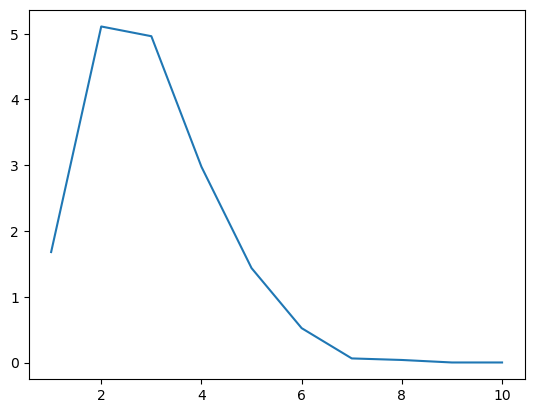

In [3]:
plt.plot(range(1,len(obs['ID'])+1),obs['ID'])

#### Now we initialize some parameters to prepare the SMCABC simulation
1. the prior

In [4]:
# in case of just one parameter
# prior = pyabc.Distribution(p=pyabc.RV("uniform",0.0,0.2))

In [5]:
# for two parameter that are not completely independent
class ConstrainedPrior(pyabc.DistributionBase):
    def __init__(self):
        self.p1 = pyabc.RV("uniform", 0., 1.)
        self.p2 = pyabc.RV("uniform", 0., 1.)
        self.max_sum = 0.8
        
    def rvs(self, *args, **kwargs):
        while True:
            p1 = self.p1.rvs()
            p2 = self.p2.rvs()
            if p1 + p2 < self.max_sum:
                return pyabc.Parameter(p1=p1,p2=p2)

    def pdf(self, x):
        p1, p2 = x["p1"], x["p2"]
        if p1 + p2 < self.max_sum:
            return self.p1.pdf(p1)*self.p2.pdf(p2)
        else:
            return 0.0
prior = ConstrainedPrior()

2. the sampler

In [6]:
# sampler = pyabc.sampler.MulticoreEvalParallelSampler()
# sampler = pyabc.sampler.SingleCoreSampler()
sampler = pyabc.sampler.DaskDistributedSampler()
sampler.show_progress=True

3. the summary statistics to be used and how to measure the distance between the reference and the simulated one. In this case we use only the Intrinsic Dimension and the $L_{\infty}$ distance

In [7]:
def ID_max(x, x0):
    sup = min( len(x["ID"]), len(x0["ID"]) )
    return np.max(abs(x["ID"][:sup] - x0["ID"][:sup]))

#def ID_sq(x, x0):
#    sup = min(len(x["ID"]),len(x0["ID"]))
#    return np.sum((x["ID"][:sup] - x0["ID"][:sup])**2)

4. initialize the SMCABC object with the model (in this case the Watts-Strogatz), the prior, the distance between summary statistics, the number of particles to be sampled and the sampler itself

In [8]:
abc = pyabc.ABCSMC(model, prior, ID_max, population_size=50, sampler=sampler)

5. Create the database where the simulation info will be saved, inserting also the reference summary statistics and, possibly, the original parameter

In [9]:
abc.new("sqlite:///data.db", observed_sum_stat=obs, gt_par=gt_dic)

ABC.History INFO: Start <ABCSMC id=1, start_time=2024-04-24 01:51:25>


6. we are finally ready to perform the simulation, providing the $\epsilon$, i.e. the distance threshold among the summary statistic beyond which we are happy and the maximum number of SMC generations

In [10]:
history1 = abc.run(minimum_epsilon=0.1, max_nr_populations=15)
sampler.shutdown()

ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.61377134e+00.
ABC INFO: Accepted: 50 / 106 = 4.7170e-01, ESS: 5.0000e+01.
ABC INFO: t: 1, eps: 9.46150222e-01.
ABC INFO: Accepted: 50 / 129 = 3.8760e-01, ESS: 4.6736e+01.
ABC INFO: t: 2, eps: 4.07748573e-01.
ABC INFO: Accepted: 50 / 157 = 3.1847e-01, ESS: 4.1537e+01.
ABC INFO: t: 3, eps: 2.90382103e-01.
ABC INFO: Accepted: 50 / 174 = 2.8736e-01, ESS: 3.8084e+01.
ABC INFO: t: 4, eps: 2.13230998e-01.
ABC INFO: Accepted: 50 / 207 = 2.4155e-01, ESS: 4.4670e+01.
ABC INFO: t: 5, eps: 1.58221442e-01.
ABC INFO: Accepted: 50 / 403 = 1.2407e-01, ESS: 4.6103e+01.
ABC INFO: t: 6, eps: 1.20341151e-01.
ABC INFO: Accepted: 50 / 669 = 7.4738e-02, ESS: 3.4538e+01.
ABC INFO: t: 7, eps: 9.89548964e-02.
ABC INFO: Accepted: 50 / 1460 = 3.4247e-02, ESS: 3.6567e+01.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=1, duration=0:06:20.087842, end_time=2024-04-24 01:57:45>


Plot the evolution of the IDS

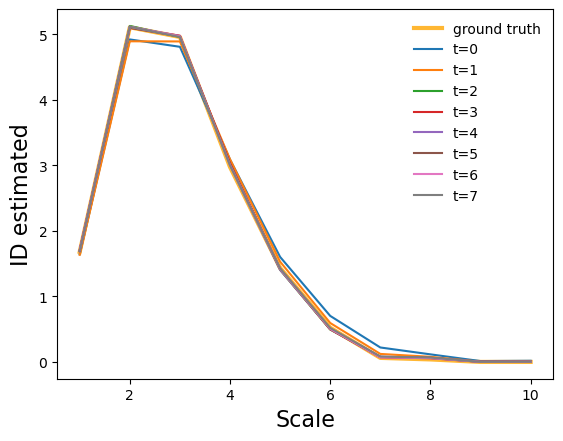

In [11]:
gp.plot_ID(history1,type='evo', t0=0, t1=8)

Plot the evolution of the posterior

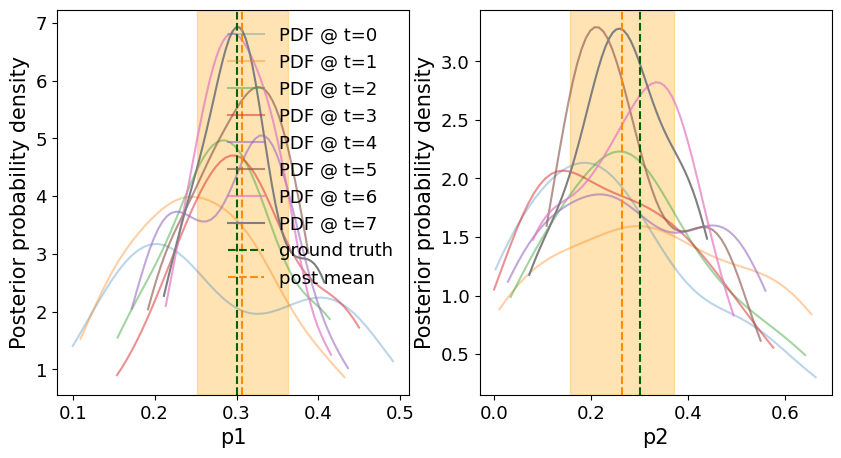

In [12]:
gp.plot_smc_evo(history1,p_true=True)

Plot the joint posterior

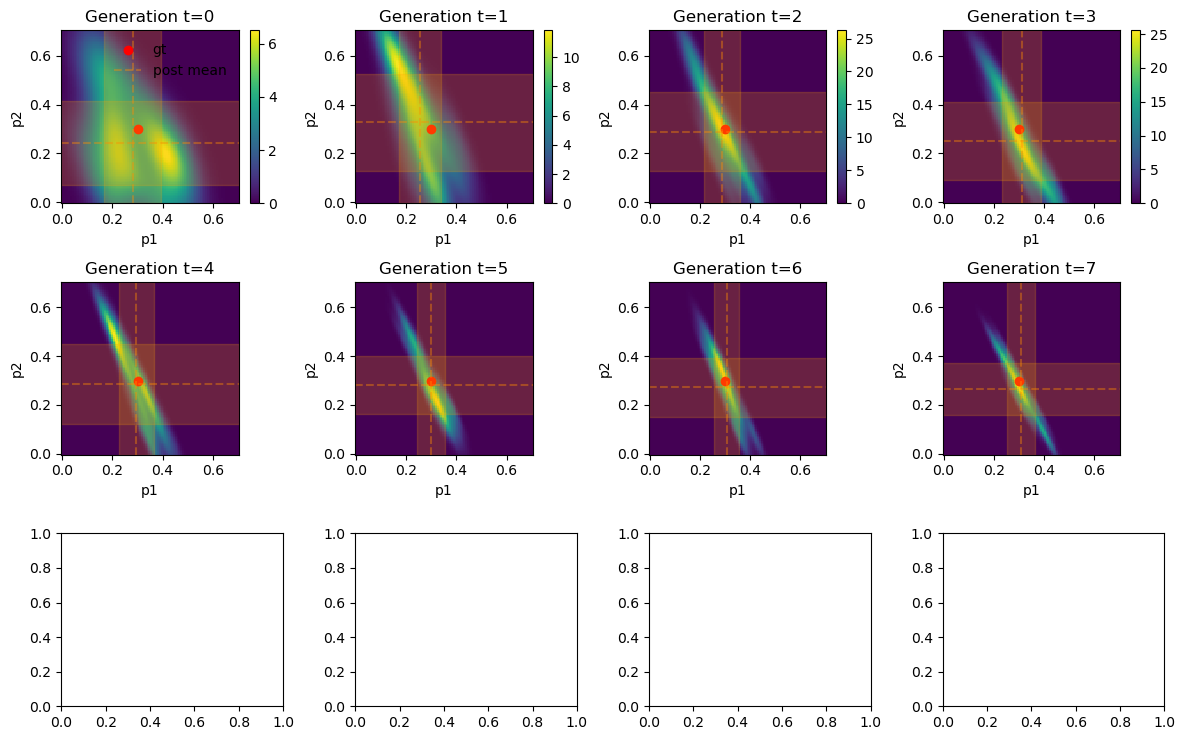

In [ ]:
gp.plot_smc_joint_evo(history1,p1='p1',p2='p2',
                     t1=13,
                      #fileout=directory+'joint.png',
                     xmin=0, xmax=0.7,
                     ymin=0, ymax=0.7,
                     #averages=False,
                     )

Plot SMC related stuff

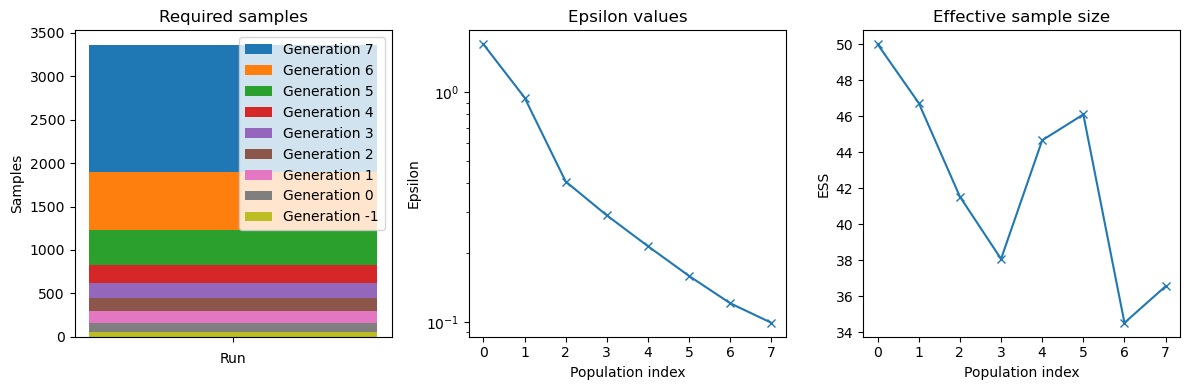

In [14]:
fig, arr_ax = plt.subplots(1, 3, figsize=(12, 4))

pyabc.visualization.plot_sample_numbers(history1, ax=arr_ax[0])
pyabc.visualization.plot_epsilons(history1, ax=arr_ax[1])
pyabc.visualization.plot_effective_sample_sizes(history1, ax=arr_ax[2])

fig.tight_layout()

#### You can now adapt this same framework to any generative model, starting from an artificial sample of that model or from an observed ID signature. In the next cell we show an example of the model function that can be integrated in the previous framework, insted of using the extended_barabasi_albert. For an executable, look at SMCABC.py